In [30]:
import os
import tensorflow as tf

In [31]:
root_dir = "notMNIST_large"

In [32]:
image_path_list = []
image_label_list = []

for label in os.listdir(root_dir):
    target_dir = os.path.join(root_dir, label)
    for image_filename in os.listdir(target_dir):
        image_path_list.append(
            os.path.join(target_dir, image_filename)
        )
        image_label_list.append(label)

In [33]:
len(image_path_list), len(image_label_list) 

(529114, 529114)

In [34]:
from sklearn.preprocessing import LabelEncoder

lbl = LabelEncoder()
image_label_list = lbl.fit_transform(image_label_list)

In [35]:
image_path_list[:3]

['notMNIST_large/I/RFRMQXJnb1RDYXBzLVVsdHJhSGVhdnkub3Rm.png',
 'notMNIST_large/I/YWNjaWVudC50dGY=.png',
 'notMNIST_large/I/RWxlZ2FudCBHYXJhbW9uZC5wZmI=.png']

In [36]:
image_label_list[:3]

array([8, 8, 8])

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_dev, X_test, y_dev, y_test = train_test_split(
    image_path_list, image_label_list, test_size=0.15,stratify=image_label_list)

In [39]:
from collections import Counter
Counter(y_test)

Counter({0: 7936,
         5: 7937,
         3: 7936,
         1: 7937,
         6: 7937,
         8: 7937,
         4: 7937,
         2: 7937,
         7: 7937,
         9: 7937})

In [40]:
X_train, X_val, y_train, y_val = train_test_split(
    X_dev, y_dev, test_size=0.20,stratify=y_dev)

In [41]:
Counter(y_val)

Counter({2: 8995,
         9: 8995,
         5: 8995,
         0: 8995,
         7: 8995,
         1: 8995,
         8: 8995,
         6: 8995,
         4: 8995,
         3: 8995})

In [42]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [43]:
for image_path in X_train[:3]:
    display.display(Image.open(str(image_path)))

In [44]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [45]:
for f in train_dataset.take(3):
    print(f)

(<tf.Tensor: id=1523, shape=(), dtype=string, numpy=b'notMNIST_large/F/QmFpbGV5IFNhbnMgSVRDIEJvbGQgSXRhbGljLnR0Zg==.png'>, <tf.Tensor: id=1524, shape=(), dtype=int64, numpy=5>)
(<tf.Tensor: id=1525, shape=(), dtype=string, numpy=b'notMNIST_large/G/TWV0YUJvb2tDRUxGLUl0YWxpY0NhcHMub3Rm.png'>, <tf.Tensor: id=1526, shape=(), dtype=int64, numpy=6>)
(<tf.Tensor: id=1527, shape=(), dtype=string, numpy=b'notMNIST_large/B/R2VvbWV0cjcwNiBNZCBCVCBCbGFjay50dGY=.png'>, <tf.Tensor: id=1528, shape=(), dtype=int64, numpy=1>)


In [50]:
class_names = {k:i for i, k in enumerate(set(y_val))}

def _preprocess_image(image):   
    image = tf.image.decode_png(image, channels=1)   
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [28, 28,])
    image /= 255.0  # normalize to [0,1] range    
    return image

def _load_and_preprocess_image(path):   
    image = tf.io.read_file(path)
    image = _preprocess_image(image)
    return image

def load_and_preprocess_from_path_label(path, label):   
    return _load_and_preprocess_image(path), label  

def get_dataset(ds):
    image_label_ds = ds.map(load_and_preprocess_from_path_label)
    image_label_ds = image_label_ds.shuffle(1024)
    image_label_ds = image_label_ds.batch(1024)
    image_label_ds = image_label_ds.prefetch(buffer_size=1024)
    return image_label_ds

In [51]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = get_dataset(train_dataset)
val_dataset = get_dataset(val_dataset)
test_dataset = get_dataset(test_dataset)


In [52]:
from __future__ import print_function

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten

In [60]:
model = Sequential()
model.add(Flatten(input_shape = (28, 28,1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=50, validation_data=val_dataset,
                    verbose=1)

score = model.evaluate(test_dataset, verbose=0)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_35 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_36 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_37 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_38 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_39 (Dense)             (None, 64)               

1406/1406 [==============================] - 30s 21ms/step - loss: 0.2208 - accuracy: 0.9303 - val_loss: 0.3382 - val_accuracy: 0.9021
Epoch 48/50
1406/1406 [==============================] - 30s 21ms/step - loss: 0.2179 - accuracy: 0.9315 - val_loss: 0.3368 - val_accuracy: 0.9037
Epoch 49/50
1406/1406 [==============================] - 30s 21ms/step - loss: 0.2183 - accuracy: 0.9312 - val_loss: 0.3404 - val_accuracy: 0.9043
Epoch 50/50
1406/1406 [==============================] - 30s 21ms/step - loss: 0.2154 - accuracy: 0.9320 - val_loss: 0.3472 - val_accuracy: 0.9025


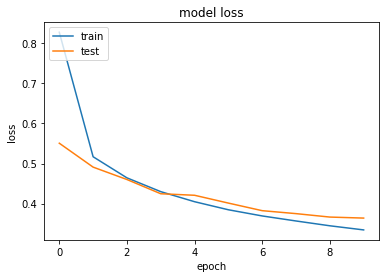

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()